In [1]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.metric import *
# import properscoring as ps
from tqdm import tqdm
# plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
torch.load("../data/london/tensor_small/y_tr.pt", weights_only=True).shape

torch.Size([16696, 48])

In [3]:
M = 20
X = torch.load("../data/london/tensor_small/y_val.pt", weights_only=True).unsqueeze(1).repeat(1, M, 1)
X_hat_gan = torch.load("../result/data/london/load_hat_gan.pt", weights_only=True)[:, :M, :]
X_hat_vae = torch.load("../result/data/london/load_hat_vae.pt", weights_only=True)[:, :M, :]
X_hat_nf = torch.load("../result/data/london/load_hat_nf.pt", weights_only=True)[:, :M, :]
X_hat_diff_base = torch.load("../result/data/london/load_hat_diff_base.pt", weights_only=True)[:, :M, :]

In [4]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
ps_gan = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_gan, quantiles), quantiles)
ps_vae = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_vae, quantiles), quantiles)
ps_nf = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_nf, quantiles), quantiles)
ps_diff_base = calculate_pinball_loss(X[:, 0, :], calculate_quantile_forecasts(X_hat_diff_base, quantiles), quantiles)

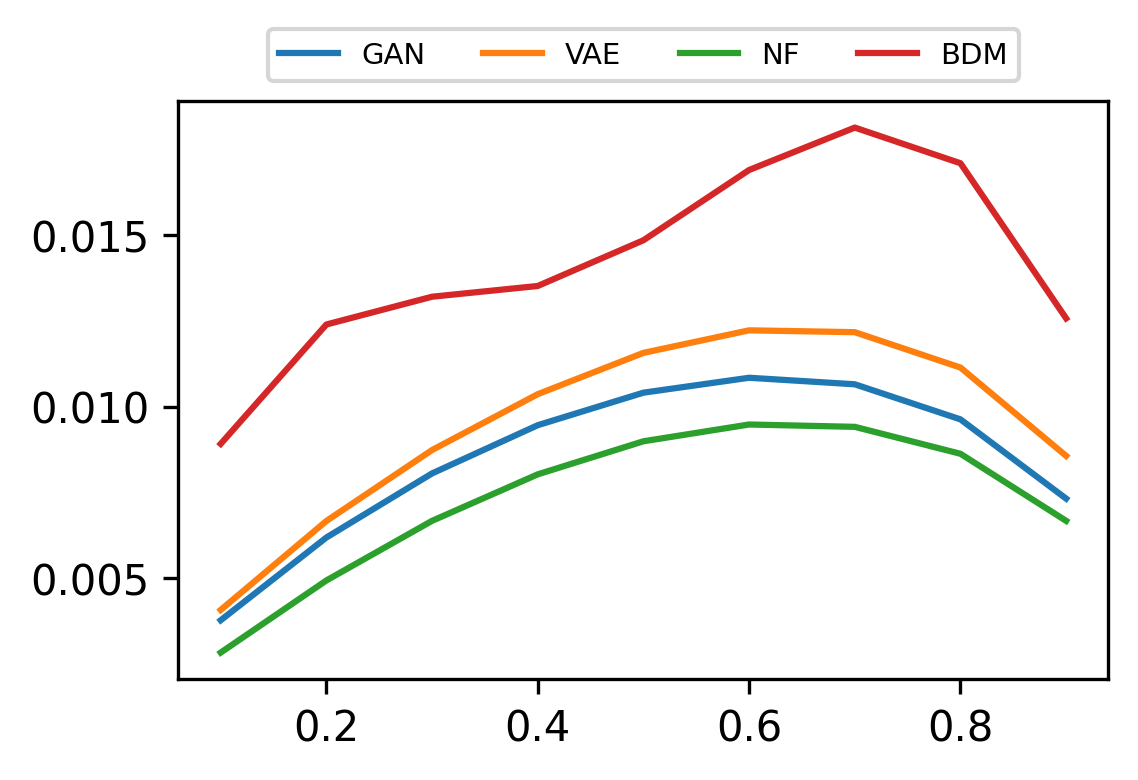

In [5]:
plt.figure(figsize=(4, 2.5), dpi=300)
plt.plot(quantiles, ps_gan, label = "GAN")
plt.plot(quantiles, ps_vae, label = "VAE")
plt.plot(quantiles, ps_nf, label = "NF")
plt.plot(quantiles, ps_diff_base, label = "BDM")
# plt.ylim(0.1, 0.8)
plt.legend(fontsize=7, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=5)
# plt.legend(fontsize=8, loc = "upper left")
plt.savefig("../result/plots/london/PS.jpg")

In [22]:
X.shape, X_hat_gan.shape, X_hat_diff_base.shape

(torch.Size([4174, 20, 48]),
 torch.Size([4174, 20, 48]),
 torch.Size([4174, 20, 48]))

In [23]:
def es(x, x_hat):
    es = 0
    term_1 = 0
    term_2 = 0
    M = x.shape[0]
    for i in range(M):
        term_1 = term_1 + torch.norm(x_hat[i] - x[i])
        for j in range(M):
            term_2 = term_2 + torch.norm(x_hat[i]- x_hat[j])
    es = es + term_1 /M  - term_2 / (2 * M**2)
    return es

In [24]:
def crps(x, x_hat):
    crps = 0
    term_1 = 0
    term_2 = 0
    M = len(x)
    for i in range(M):
        term_1 = term_1 + torch.abs(x_hat[i] - x[i])
        for j in range(M):
            term_2 = term_2 + torch.abs(x_hat[i]- x_hat[j])
    crps = crps + term_1 /M  - term_2 / (2 * M**2)
    return crps

In [25]:
def vs(x, x_hat):
    x = x.T
    x_hat = x_hat.T # [96, 20]
    T = x.shape[0]
    vs = 0
    for i in range(T):
            for j in range(i+1, T):
                term_1 = torch.sqrt(torch.abs(x[i][0] - x[j][0]))
                term_2 = torch.mean(torch.sqrt(torch.abs(x_hat[i] - x_hat[j])))
                vs = vs + (term_1 - term_2) ** 2
    return vs
    

In [26]:
def crps_margin(X, X_hat):
    # CRPS
    TS = X.shape[0] # num of test data
    T = X.shape[2]
    CRPS = []
    for i in tqdm(range(T)):
        temp = 0
        for j in range(TS):
            x = X[j, :, i]
            x_hat = X_hat[j, :, i]
            temp = temp + crps(x, x_hat)
        CRPS.append(temp/TS)
    return CRPS

In [27]:
CRPS_gan = crps_margin(X, X_hat_gan)
CRPS_vae = crps_margin(X, X_hat_vae)
CRPS_nf = crps_margin(X, X_hat_nf)
CRPS_diff_base = crps_margin(X, X_hat_diff_base)


  2%|▏         | 1/48 [00:07<06:08,  7.84s/it]


KeyboardInterrupt: 

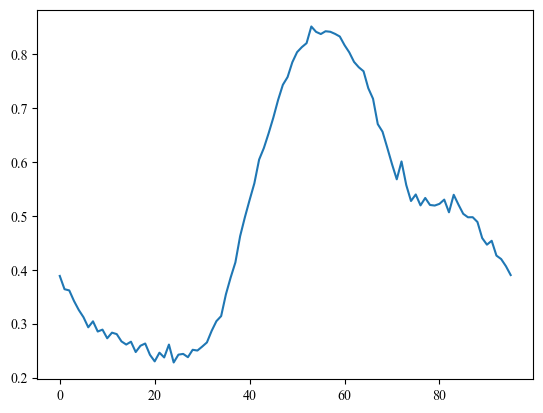

In [73]:
plt.plot(CRPS_gan)

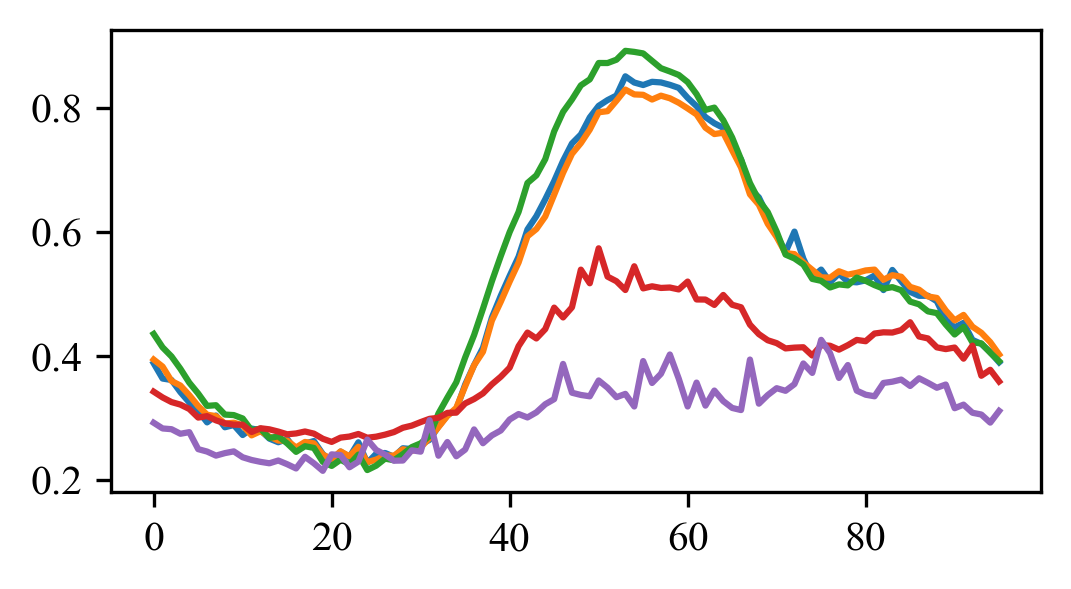

In [74]:
plt.figure(figsize=(4, 2), dpi=300)
plt.plot(CRPS_gan, label = "GAN")
plt.plot(CRPS_vae, label = "VAE")
plt.plot(CRPS_nf, label = "NF")
plt.plot(CRPS_diff_base, label = "BDM")
# plt.legend(fontsize=8)
plt.savefig("./result/plots/CRPS.jpg")

Load Forecasting Metric: MAE and RMSE

In [75]:
def evaluation(X, X_hat):
    TS = X.shape[0] # num of test data
    M = X.shape[1] # num of senarios
    T = X.shape[2]
    # MAE; RMSE
    MAE = 0
    RMSE = 0
    
    for i in tqdm(range(TS)):
        for j in range(M):
            x = X[i, j, :]
            x_hat = X_hat[i, j, :]
            MAE = MAE + mean_absolute_error(x,x_hat)
            RMSE = RMSE + mean_squared_error(x, x_hat)
    MAE = MAE / (TS * M)
    RMSE = RMSE / (TS * M)
    print(f'MAE: {MAE:.4f}')
    print(f'RMSE: {RMSE:.4f}')
    # PS
    PS = np.mean(pinball_Loss(X, X_hat))
    print(f'PS: {PS:.4f}')
    # CRPS
    CRPS = 0
    for i in tqdm(range(T)):
        for j in range(TS):
            x = X[j, :, i]
            x_hat = X_hat[j, :, i]
            CRPS = CRPS + crps(x, x_hat)
    CRPS = CRPS / (T * TS)
    print(f'CRPS: {CRPS:.4f}')
    # ES
    ES = 0
    for i in tqdm(range(TS)):
        x = X[i]
        x_hat = X_hat[i]
        ES = ES + es(x, x_hat)
    ES = ES / TS
    print(f'ES: {ES:.4f}')
    # VS
    VS = 0
    for i in tqdm(range(TS)):
        VS = VS + vs(X[i], X_hat[i])
    VS = VS / TS
    print(f'VS: {VS:.4f}')


In [76]:
evaluation(X, X_hat_nf)

100%|██████████| 2190/2190 [00:16<00:00, 130.01it/s]


MAE: 0.9574
RMSE: 1.9011
PS: 0.2778


100%|██████████| 96/96 [08:10<00:00,  5.11s/it]


CRPS: 0.5092


100%|██████████| 2190/2190 [00:07<00:00, 311.35it/s]


ES: 6.8487


100%|██████████| 2190/2190 [03:51<00:00,  9.45it/s]

VS: 1140.9404


In [77]:
evaluation(X, X_hat_vae)

100%|██████████| 2190/2190 [00:17<00:00, 126.37it/s]


MAE: 0.8825
RMSE: 1.5551
PS: 0.2678


100%|██████████| 96/96 [08:07<00:00,  5.08s/it]


CRPS: 0.4897


100%|██████████| 2190/2190 [00:07<00:00, 308.16it/s]


ES: 6.3725


100%|██████████| 2190/2190 [03:50<00:00,  9.50it/s]

VS: 967.4344


In [78]:
evaluation(X, X_hat_gan)

  0%|          | 0/2190 [00:00<?, ?it/s]

100%|██████████| 2190/2190 [00:16<00:00, 129.25it/s]


MAE: 0.8859
RMSE: 1.5786
PS: 0.2661


100%|██████████| 96/96 [08:11<00:00,  5.12s/it]


CRPS: 0.4926


100%|██████████| 2190/2190 [00:07<00:00, 311.94it/s]


ES: 6.4477


100%|██████████| 2190/2190 [03:51<00:00,  9.47it/s]

VS: 975.4125


In [80]:
evaluation(X, X_hat_diff_base)

100%|██████████| 2190/2190 [00:17<00:00, 128.47it/s]


MAE: 0.8665
RMSE: 1.2816
PS: 0.2155


100%|██████████| 96/96 [08:09<00:00,  5.10s/it]


CRPS: 0.3878


100%|██████████| 2190/2190 [00:06<00:00, 316.71it/s]


ES: 4.8046


100%|██████████| 2190/2190 [03:49<00:00,  9.56it/s]

VS: 850.5711
